# 📊 Análisis de Regresión Lineal: Duración de Estancia Hospitalaria
En este notebook realizaremos un análisis de regresión lineal utilizando datos del proyecto **EpiScopeEnvigado**, con el objetivo de explicar los factores que influyen en la duración de estancia hospitalaria.

## 🧩 Variables a analizar
- **Dependiente:** `Duracion_Estancia`
- **Independientes:** `via_ingreso_id`, `estado_salida_id`, `causa_ext_id`, `Estado_Salida`, `EDAD_ANIOS`, `SEXO`, `capitulo`


In [16]:
# 🔧 Importación de librerías necesarias
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# 📦 Funciones personalizadas del proyecto
from episcopeenvigado.dataset import obtener_dataset_completo
from episcopeenvigado.etl_modules.unificar_tablas import unificar_dataset



## 📥 1. Cargar los datos
Primero, cargamos el dataset completo desde la base de datos del proyecto y lo unificamos en un único `DataFrame`.

In [17]:
data = obtener_dataset_completo()
df_unificado = unificar_dataset(data)
df_unificado.head()

2025-11-10 19:22:10.048 | INFO     | episcopeenvigado.dataset:obtener_dataset_completo:110 - 📋 Se encontraron 7 tablas en la base de datos.
2025-11-10 19:22:10.054 | SUCCESS  | episcopeenvigado.dataset:obtener_dataset_completo:119 - ✅ Tabla 'dim_causa_ext' cargada correctamente (14 filas).
2025-11-10 19:22:10.318 | SUCCESS  | episcopeenvigado.dataset:obtener_dataset_completo:119 - ✅ Tabla 'dim_cie10' cargada correctamente (12568 filas).
2025-11-10 19:22:10.324 | SUCCESS  | episcopeenvigado.dataset:obtener_dataset_completo:119 - ✅ Tabla 'dim_departamento' cargada correctamente (34 filas).
2025-11-10 19:22:10.327 | SUCCESS  | episcopeenvigado.dataset:obtener_dataset_completo:119 - ✅ Tabla 'dim_estado_salida' cargada correctamente (2 filas).
2025-11-10 19:22:10.341 | SUCCESS  | episcopeenvigado.dataset:obtener_dataset_completo:119 - ✅ Tabla 'dim_municipio' cargada correctamente (1124 filas).
2025-11-10 19:22:10.345 | SUCCESS  | episcopeenvigado.dataset:obtener_dataset_completo:119 - ✅ Tab

,fact_id,Cod_IPS,ID,Fecha_Ingreso,Fecha_Egreso,Duracion_Dias,via_ingreso_id,estado_salida_id,municipio_id,causa_ext_id,...,municipio_dane,departamento_cod_y,Municipio_Desc,estado_salida_cod,Estado_Salida_Desc,via_ingreso_cod,Via_Ingreso_Desc,cie_4cat,Diagnostico_Principal_Desc,Capitulo_CIE10
0,1,52660212605,PAC00001,2023-09-04,2023-09-14,10,3,1,114,12,...,05266,05,ENVIGADO,1,VIVO,3,REMITIDO,F28X,Otros trastornos psicoticos de origen no orga...,Trastornos mentales y del comportamiento (F00-...
1,2,52660212605,PAC00002,2023-02-05,2023-02-28,23,2,1,114,12,...,05266,05,ENVIGADO,1,VIVO,2,CONSULTA EXTERNA,A971,Dengue con signos de alarma,Ciertas enfermedades infecciosas y parasitaria...
2,3,52660212605,PAC00003,2023-09-30,2023-09-30,0,3,1,1,12,...,05001,05,MEDELLÍN,1,VIVO,3,REMITIDO,B159,"Hepatitis aguda tipo A, sin coma hepatico",Ciertas enfermedades infecciosas y parasitaria...
3,4,52660212605,PAC00004,2023-08-31,2023-09-29,29,3,1,1,12,...,05001,05,MEDELLÍN,1,VIVO,3,REMITIDO,G042,Meningoencefalitis y meningomielitis bacterian...,Enfermedades del sistema nervioso (G00-G99)
4,5,52660212605,PAC00005,2023-08-26,2023-09-01,6,3,1,1,2,...,05001,05,MEDELLÍN,1,VIVO,3,REMITIDO,S822,Fractura de la diafisis de la tibia,"Traumatismos, envenenamiento y algunas otras c..."


## 🧹 2. Preparación de los datos
Filtramos los casos sin información de duración de estancia y seleccionamos las variables necesarias para la regresión.

In [18]:
# 🧩 Selección de variables para el modelo
# En este paso seleccionamos las variables relevantes para analizar la duración de la estancia hospitalaria.
# Usamos los nombres reales de las columnas según el DataFrame 'df_unificado'.

variables_usadas = [
    'via_ingreso_id',       # Tipo de vía de ingreso del paciente
    'estado_salida_id',     # Estado al egreso
    'causa_ext_id',         # Causa externa asociada
    'EDAD_ANIOS',           # Edad del paciente
    'SEXO',                 # Sexo del paciente
    'Capitulo_CIE10'        # Capítulo del diagnóstico principal según CIE-10
]

# Filtramos las variables seleccionadas junto con la variable dependiente 'Duracion_Dias'
# y eliminamos registros con valores faltantes.
df_modelo = df_unificado[variables_usadas + ['Duracion_Dias']].dropna()

# Mostramos las primeras filas del dataset resultante para verificar que la selección sea correcta.
df_modelo.head()

,via_ingreso_id,estado_salida_id,causa_ext_id,EDAD_ANIOS,SEXO,Capitulo_CIE10,Duracion_Dias
0,3,1,12,29.0,F,Trastornos mentales y del comportamiento (F00-...,10
1,2,1,12,22.0,M,Ciertas enfermedades infecciosas y parasitaria...,23
2,3,1,12,22.0,F,Ciertas enfermedades infecciosas y parasitaria...,0
3,3,1,12,23.0,M,Enfermedades del sistema nervioso (G00-G99),29
4,3,1,2,22.0,M,"Traumatismos, envenenamiento y algunas otras c...",6


## 📈 3. Análisis exploratorio
Veamos la distribución de la variable dependiente y relaciones con algunas independientes.

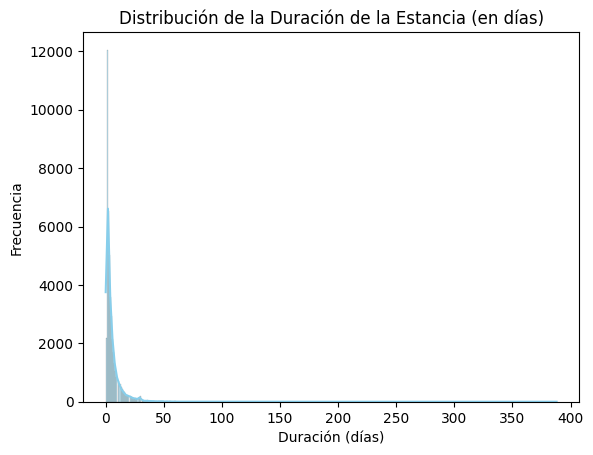

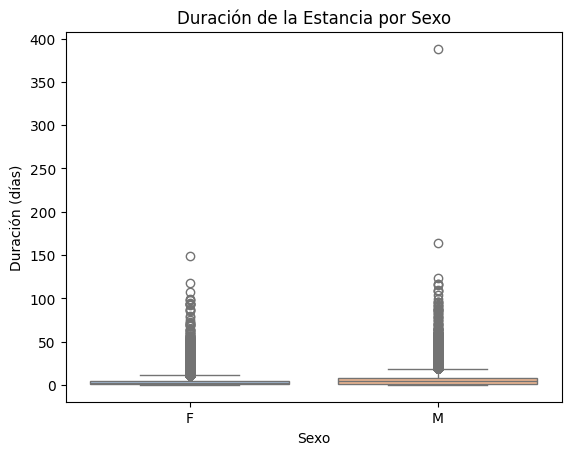

In [19]:

# Histograma con curva de densidad
sns.histplot(df_modelo['Duracion_Dias'], kde=True, color='skyblue')
plt.title('Distribución de la Duración de la Estancia (en días)')
plt.xlabel('Duración (días)')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de caja por sexo (corregido)
sns.boxplot(x='SEXO', y='Duracion_Dias', data=df_modelo, hue='SEXO', palette='pastel', legend=False)
plt.title('Duración de la Estancia por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Duración (días)')
plt.show()

## 📊 4. Modelo de Regresión Lineal
Ajustamos un modelo de regresión lineal múltiple para estimar los coeficientes de cada variable predictora.

In [27]:
import pandas as pd
import statsmodels.api as sm

# ===============================
# 🔹 Definir variables
# ===============================
variables_numericas = ['EDAD_ANIOS', 'Duracion_Dias']
variables_categoricas = ['SEXO', 'via_ingreso_id', 'causa_ext_id', 'Capitulo_CIE10']

# ===============================
# 🔹 Crear DataFrame de trabajo
# ===============================
# (suponiendo que tu DataFrame original se llama df_modelo)
df_modelo = df_modelo.copy()

# ===============================
# 🔹 Crear variables dummy
# ===============================
X_cat = pd.get_dummies(df_modelo[variables_categoricas], drop_first=True)

# Combinar numéricas + categóricas dummy
X = pd.concat([df_modelo[['EDAD_ANIOS']], X_cat], axis=1)

# Agregar constante (intercepto)
X = sm.add_constant(X)

# ===============================
# 🔹 Variable dependiente
# ===============================
y = df_modelo['Duracion_Dias']

# ===============================
# 🔹 Alinear índices y eliminar NaN
# ===============================
mask = X.notnull().all(axis=1) & y.notnull()
X = X.loc[mask]
y = y.loc[mask]

# ===============================
# 🔹 Convertir booleanos a float
# ===============================
X = X.astype(float)

# ===============================
# 🔹 Ajustar modelo
# ===============================
modelo = sm.OLS(y, X).fit()

# ===============================
# 🔹 Resultados
# ===============================
print(modelo.summary())



                            OLS Regression Results                            
Dep. Variable:          Duracion_Dias   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     106.8
Date:                Mon, 10 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:30:23   Log-Likelihood:            -1.5541e+05
No. Observations:               45297   AIC:                         3.109e+05
Df Residuals:                   45252   BIC:                         3.113e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                                                                                                                                         coef    std err          t      P>|t|      [0.025      0.

## 📉 5. Interpretación de resultados
- **Coeficiente:** efecto esperado de cada variable sobre la duración de estancia.
- **t-Valor y p-Valor:** indican si el efecto es estadísticamente significativo.
- **R²:** proporción de la variabilidad de la duración explicada por las variables.

In [28]:
coef_df = pd.DataFrame({
    'Variable': modelo.params.index,
    'Coeficiente': modelo.params.values,
    'Error Std': modelo.bse.values,
    't-Valor': modelo.tvalues.values,
    'p-Valor': modelo.pvalues.values
})
coef_df

,Variable,Coeficiente,Error Std,t-Valor,p-Valor
0,const,4.949381,1.035148,4.781325,1.746903e-06
1,EDAD_ANIOS,0.025482,0.001658,15.366200,3.759732e-53
2,SEXO_M,0.779120,0.076682,10.160391,3.162738e-24
3,via_ingreso_id_2,-3.054836,0.189149,-16.150450,1.644075e-58
4,via_ingreso_id_3,0.609906,0.082360,7.405320,1.331042e-13
5,via_ingreso_id_4,3.755063,0.407203,9.221599,3.049010e-20
6,via_ingreso_id_5,-1.568843,0.871644,-1.799867,7.188835e-02
7,via_ingreso_id_6,2.734332,1.107216,2.469557,1.353171e-02
8,via_ingreso_id_7,11.768040,1.439126,8.177212,2.979637e-16
9,via_ingreso_id_8,-5.845910,5.299047,-1.103200,2.699461e-01


## ✅ 6. Conclusiones
- Las variables con **p-valor < 0.05** se consideran **significativas**.
- Un **coeficiente positivo** indica un aumento esperado en la duración de estancia, y uno **negativo** indica una reducción.
- Este modelo permite identificar qué factores clínicos y administrativos influyen más en la estancia hospitalaria.